In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import PIL.Image as Image 
import matplotlib.image as img
import os

In [2]:
# read an image and convert it to a binary pattern of size [Lx, Ly]: 
# arguments = figurename, final size=[Lx, Ly]
def readPatterns(fname, size):
    this_img = Image.open(fname) # open colour image
    this_img = this_img.convert('1') # convert image to black and white
    this_img = this_img.resize(size=[size[0],size[1]]) # resize it to have the dimensions [Lx, Ly]
    this_img.save("%s_converted.png"%fname) # save converted image

    # plot the original and the converted file
    fig = plt.figure()

    # subplot on the left - original figure
    fig.add_subplot(1,2,1)
    original = img.imread(fname)
    plt.imshow(original)
    plt.title("original")
    plt.axis('off')

    # subplot on the right - converted figure
    matrix = img.imread("%s_converted.png"%fname) # re-read from the file and convert it to a matrix of [0.,1.]
    matrix = 2*matrix-1 # convert from [0.,1.] -> [-1,1]
    fig.add_subplot(1,2,2)		
    plt.matshow(matrix, cmap=plt.cm.gray,fignum=0)
    plt.axis('off')
    plt.title("simplified")
    plt.show()

    # Return the pattern as a 1D vector (not as a 2D a matrix)
    return matrix.flatten()

In [3]:
class HopfieldNet:
    # initialize: 
    # arguments = number of neurons, list of patterns (vector of M components, each element of the pattern has to be an array of -1,+1 of size N)
    def __init__(self, N, patterns):
        self.N = N
        self.time_elapsed = 0.

        self.w = np.zeros([N,N]) # weights
        self.h = np.zeros(N) # threshold functions

        self.s = -np.ones(N) # default configuration = s[i]=-1
        
        # HEBBIAN RULE (h_i = 0., w_{ij} = sum_{k=1,...,M} s_i^k*s_j^k / M)
        print ("The network is learning...")
        self.M = len(patterns)
        for k in range(self.M):
            print("pattern ", k)
        # this is not efficient, but we could use it anyway:
        #for i in range(self.N):
        #for j in range(self.N):
        #self.w[i,j] += patterns[k][i]*patterns[k][j]/(1.*self.M)

        # it is more efficient to use built-in functions:
        self.w += np.outer(patterns[k],patterns[k])/(1.*self.M)
        
        print("Done!")


        ## COMPUTE THE ENERGY - As before, I avoid loops and use efficient functions
        self.E = -0.5*np.sum(self.w) - np.sum(self.h) # energy for s_i = -1

        return

    # given and input s=[s_1,s_2,...,s_N], set the state of the network and recompute the energy
    def set_state(self, sinput):
        self.s = np.copy(sinput)

        # COMPUTE THE ENERGY - I use efficient functions rather than loops
        s2 = np.outer(self.s, self.s) # this returns a matrix s2[i,j]=s[i]*s[j]
        self.E = -0.5*np.sum(self.w*s2) + np.sum(self.h*self.s)
        return
    
    def evolve(self, steps):
        for t in range(steps):
            i = np.random.randint(self.N)  # choose one node randomly

            sum_wijsj = np.sum(self.w[i, :] * self.s)  # compute the argument of the activation function
            if sum_wijsj < self.h[i]:  # below the threshold
                self.s[i] = -1
            else:  # above the threshold
                self.s[i] = 1

        return


Reading images and converting to binary patterns...


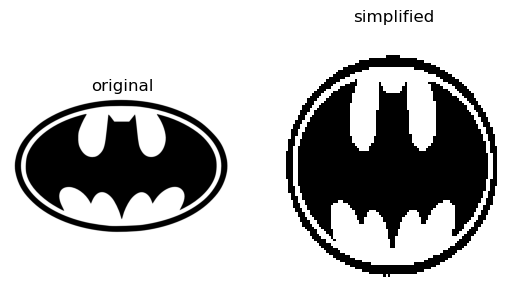

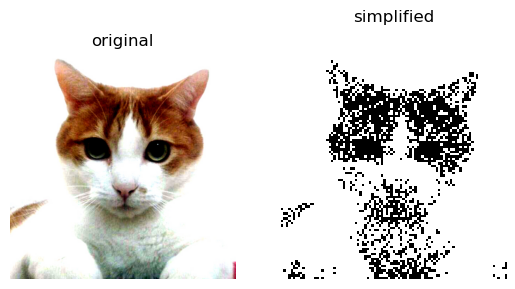

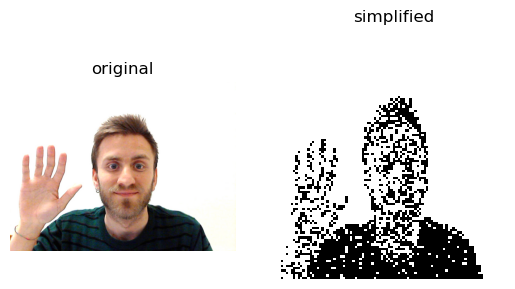

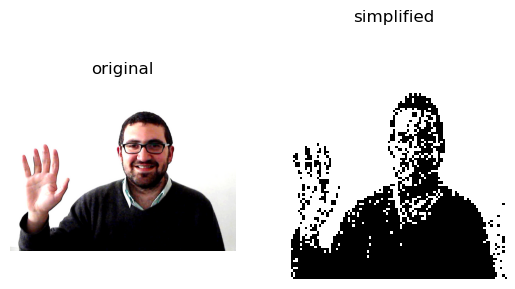

Done!


In [4]:
# dimensions of the images
Lx = Ly = 95
N = Lx*Ly # number of neurons


## STEP 1: READ THE IMAGES AND CONVERT THEM TO BINARY PATTERNS

# list of images that I want to store in my network
files = ["stored/batman.png", "stored/cat.jpg", "stored/jordi.jpg", "inputs/samir.jpg"]

print ("Reading images and converting to binary patterns...")
patterns = []
for fname in files:
    patterns.append(readPatterns(fname, size=[Lx,Ly]))
print ("Done!")

In [5]:
# Assuming 'patterns' is a list of binary patterns obtained from images
hopfield_network = HopfieldNet(N, patterns)

# Set an initial state (e.g., a noisy pattern)
initial_state = np.random.choice([-1, 1], size=N)
hopfield_network.set_state(initial_state)

# Evolve the network to retrieve or complete the pattern
hopfield_network.evolve(steps=1000)

# The final state of the network can be accessed through hopfield_network.s
final_state = hopfield_network.s
final_ene = hopfield_network.E

print(final_ene)

The network is learning...
pattern  0
pattern  1
pattern  2
pattern  3
Done!
-1830.125


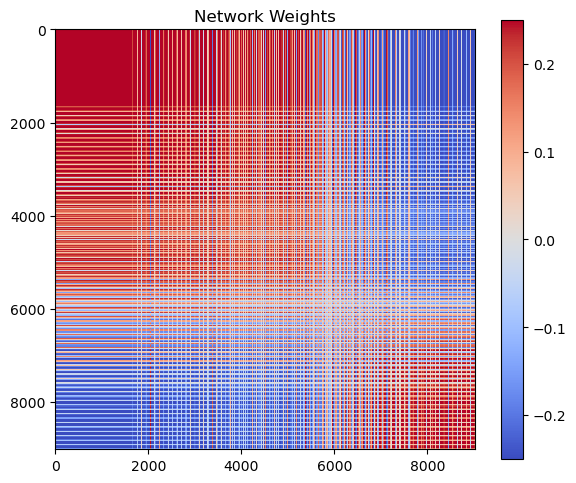

In [6]:
import matplotlib.cm as cm
plt.figure(figsize=(6, 5))
weights = hopfield_network.w
w_mat = plt.imshow(weights, cmap=cm.coolwarm)
plt.colorbar(w_mat)
plt.title("Network Weights")
plt.tight_layout()
plt.savefig("weights.png")
plt.savefig('network_weights.png')
plt.show()

#### Can the original image be restored if half of the pixels are masked out? The masked image is:

Reading images and converting to binary patterns...


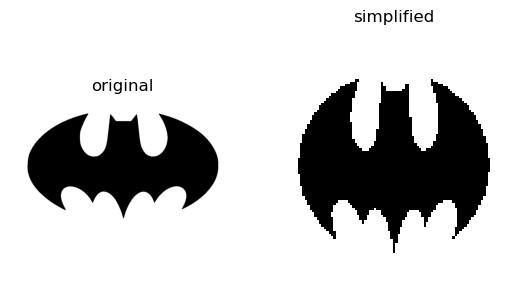

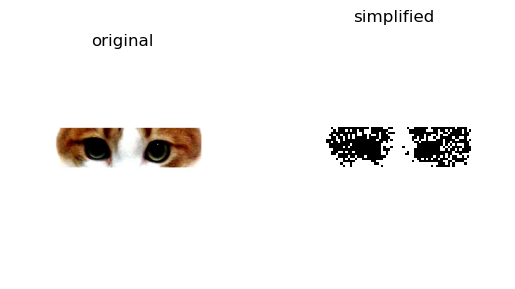

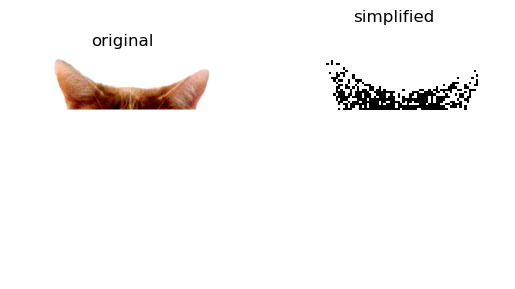

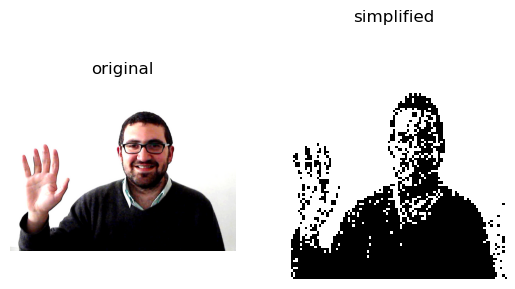

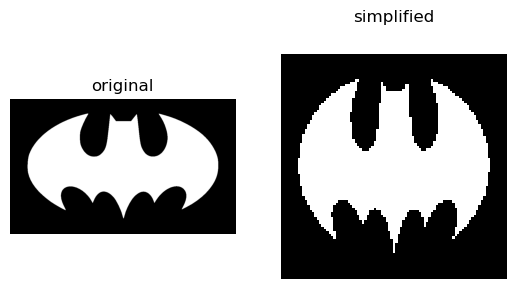

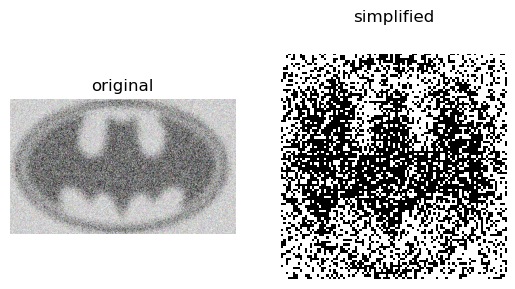

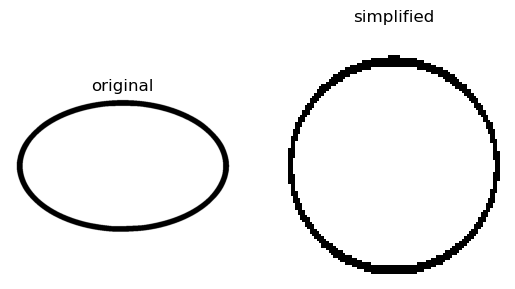

Done!


In [22]:
files_half = ["inputs/batman3.png", "inputs/cat2.jpg", "inputs/cat3.jpg", "inputs/samir.jpg", "inputs/batman4.png","inputs/batman2.png", "inputs/batman5.png"]

print ("Reading images and converting to binary patterns...")
patterns_half = []
for fname in files_half:
    patterns_half.append(readPatterns(fname, size=[Lx,Ly]))
print ("Done!")

The network is learning...
pattern  0
pattern  1
pattern  2
pattern  3
Done!


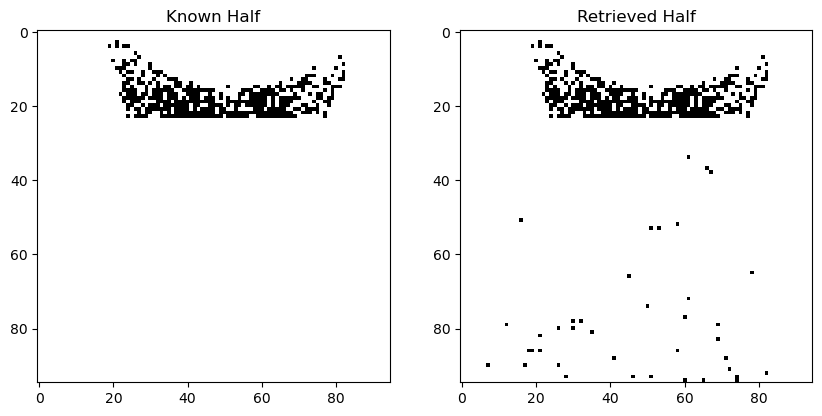

In [8]:

# Initialize and train the Hopfield network
hopfield_network = HopfieldNet(N, patterns_half)

# Set the initial state to the known half of the image
known_half = patterns_half[2]  # Assuming the first pattern is the known half
hopfield_network.set_state(known_half)

# Evolve the network to retrieve or complete the other half of the image
evolution_steps = 100
hopfield_network.evolve(evolution_steps)

# The final state of the network can be accessed through hopfield_network.s
retrieved_half = hopfield_network.s

# Reshape the retrieved half to the original image size
retrieved_image = np.reshape(retrieved_half, (Lx, Ly))

# Display the original and retrieved halves of the image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(known_half.reshape((Lx, Ly)), cmap='gray')
axes[0].set_title('Known Half')
axes[1].imshow(retrieved_image, cmap='gray')
axes[1].set_title('Retrieved Half')
plt.show()

The network is learning...
pattern  0
Done!


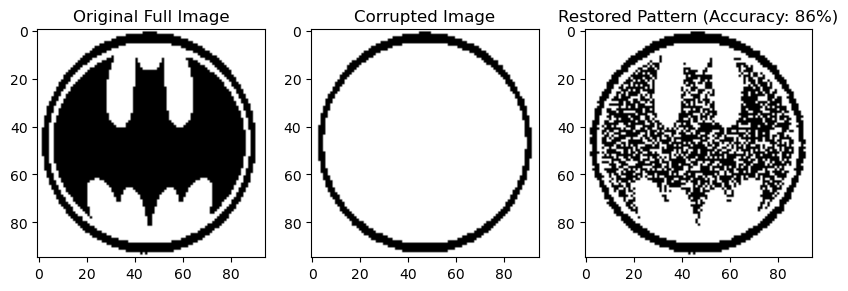

In [23]:
# Assuming patterns and patterns_half are already defined
full_image = patterns[0]
half_image = patterns_half[6]

# Initialize and evolve the Hopfield network
hopfield_net = HopfieldNet(len(full_image), [full_image])
hopfield_net.set_state(half_image)
hopfield_net.evolve(10000)
reconstructed_full_image = hopfield_net.s

# Plot the images
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(np.reshape(full_image, (int(np.sqrt(len(full_image))), -1)), cmap='gray')
plt.title('Original Full Image')

plt.subplot(1, 3, 2)
plt.imshow(np.reshape(half_image, (int(np.sqrt(len(half_image))), -1)), cmap='gray')
plt.title('Corrupted Image')

plt.subplot(1, 3, 3)
plt.imshow(np.reshape(reconstructed_full_image, (int(np.sqrt(len(reconstructed_full_image))), -1)), cmap='gray')
plt.title(f"Restored Pattern (Accuracy: {np.sum(np.asarray(full_image) == np.asarray(reconstructed_full_image)) * 100 // np.prod(full_image.size)}%)")
plt.savefig('batmanrestore4.png')
plt.show()

In [10]:
masked_half_image

NameError: name 'masked_half_image' is not defined

In [ ]:
# Assuming patterns and patterns_half are already defined
full_image = patterns[1]
half_image = patterns_half[1]

# Define a directory to save the images
save_dir = 'saved_images'
os.makedirs(save_dir, exist_ok=True)


for i in range(9):
    # Assuming patterns and patterns_half are already defined
    full_image = patterns[1]
    half_image = patterns_half[1]


    # Apply the mask to create a half-sized image
    factor = 0.1 + i*0.1
    threshold = int(len(half_image) * factor)  # Adjust the threshold as needed
    masked_half_image = np.copy(full_image)
    masked_half_image[:threshold] = 1

    # Initialize and evolve the Hopfield network
    hopfield_net = HopfieldNet(len(full_image), [full_image])
    hopfield_net.set_state(masked_half_image)
    hopfield_net.evolve(5000)
    reconstructed_full_image = hopfield_net.s

    # Plot the images
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(np.reshape(full_image, (int(np.sqrt(len(full_image))), -1)), cmap='gray')
    plt.title('Original Full Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.reshape(masked_half_image, (int(np.sqrt(len(masked_half_image))), -1)), cmap='gray')
    plt.title(f"Corrupted Pattern ({factor*100:.0f}% Masked)")

    plt.subplot(1, 3, 3)
    plt.imshow(np.reshape(reconstructed_full_image, (int(np.sqrt(len(reconstructed_full_image))), -1)), cmap='gray')
    plt.title(f"Restored Pattern (Accuracy: {np.sum(np.asarray(full_image) == np.asarray(reconstructed_full_image)) * 100 // np.prod(full_image.size)}%)")
    plt.subplots_adjust(wspace=0.7)
    
    # Save the figure
    save_filename = os.path.join(save_dir, f'result_{i}.png')
    plt.savefig(save_filename)
    plt.close()  # Close the figure to avoid displaying it multiple times
    
    plt.show()
# Optional: Display a message after all images are saved
print(f"All images saved to {save_dir}")



In [ ]:
# Assuming patterns and patterns_half are already defined
full_image = patterns[0]
half_image = patterns_half[0]

# Initialize and evolve the Hopfield network
hopfield_net = HopfieldNet(len(full_image), [full_image])
hopfield_net.set_state(half_image)
hopfield_net.evolve(10000)
reconstructed_full_image = hopfield_net.s

# Plot the images
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(np.reshape(full_image, (int(np.sqrt(len(full_image))), -1)), cmap='gray')
plt.title('Original Full Image')

plt.subplot(1, 3, 2)
plt.imshow(np.reshape(half_image, (int(np.sqrt(len(half_image))), -1)), cmap='gray')
plt.title('Half-Sized Image')

plt.subplot(1, 3, 3)
plt.imshow(np.reshape(reconstructed_full_image, (int(np.sqrt(len(reconstructed_full_image))), -1)), cmap='gray')
plt.title(f"Restored Pattern (Accuracy: {np.sum(np.asarray(full_image) == np.asarray(reconstructed_full_image)) * 100 // np.prod(full_image.size)}%)")

plt.show()

The network is learning...
pattern  0
Done!


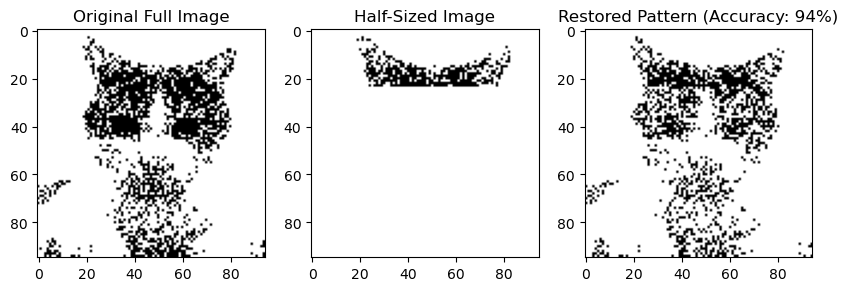

In [11]:
# Assuming patterns and patterns_half are already defined
full_image = patterns[1]
half_image = patterns_half[2]

# Initialize and evolve the Hopfield network
hopfield_net = HopfieldNet(len(full_image), [full_image])
hopfield_net.set_state(half_image)
hopfield_net.evolve(10000)
reconstructed_full_image = hopfield_net.s

# Plot the images
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(np.reshape(full_image, (int(np.sqrt(len(full_image))), -1)), cmap='gray')
plt.title('Original Full Image')

plt.subplot(1, 3, 2)
plt.imshow(np.reshape(half_image, (int(np.sqrt(len(half_image))), -1)), cmap='gray')
plt.title('Half-Sized Image')

plt.subplot(1, 3, 3)
plt.imshow(np.reshape(reconstructed_full_image, (int(np.sqrt(len(reconstructed_full_image))), -1)), cmap='gray')
plt.title(f"Restored Pattern (Accuracy: {np.sum(np.asarray(full_image) == np.asarray(reconstructed_full_image)) * 100 // np.prod(full_image.size)}%)")

plt.show()

In [132]:
reconstructed_full_image

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)